<a href="https://colab.research.google.com/github/stefan1893/TM-VI/blob/main/02_small_and_shallow_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small and shallow networks

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import sys
%load_ext autoreload
%autoreload 2


try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_fast.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_utils_keras.py
    !wget https://github.com/stefan1893/TM-VI/blob/main/ipynb/02_small_and_shallow_networks.npz?raw=true -O 02_small_and_shallow_networks.npz

    sys.path.append(".")
    import vimlts_utils_keras as VIMLTS_utils
    from vimlts import VIMLTS
    from vigauss_keras import DenseVIGAUSS
    from vimlts_fast import VimltsLinear
except:
    IN_COLAB = False
    sys.path.append('../')
    import src.vimlts_utils_keras as VIMLTS_utils
    from src.vimlts import VIMLTS
    from src.vigauss_keras import DenseVIGAUSS
    from src.vimlts_keras import DenseVIMLTS
    from src.vimlts_fast import VimltsLinear
    # Use GPU
    # physical_devices = tf.config.list_physical_devices('GPU')
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_probability as tfp
import tensorflow.keras as keras
import pandas as pd
import pystan
import scipy.stats as stats
import scipy.signal
import seaborn as sns
import tqdm
import datetime
import sys
import ctypes
import pickle
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras import callbacks, optimizers
from IPython.display import display, clear_output, HTML
from numpy import trapz
from scipy.stats import norm


tfd=tfp.distributions

print('Tensorflow version: ',tf.__version__, )

--2021-06-09 14:49:41--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8100 (7.9K) [text/plain]
Saving to: ‘vimlts.py’

vimlts.py           100%[===================>]   7.91K  --.-KB/s    in 0s      

2021-06-09 14:49:42 (82.0 MB/s) - ‘vimlts.py’ saved [8100/8100]

--2021-06-09 14:49:42--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6608 (6.5K) [text/plain]
Saving to: ‘vigauss_ker

## Data generating process

In [2]:
def get_toy_data_3(
    noise_scale,
    train_size,
    test_size,
    true_size,
    use_hole
):
    tf.random.set_seed(2)

    train_xlim = 6.
    test_xlim = 6.5
    true_xlim = 6.5

    # True function
    target_fn = lambda x: np.sin(x)

    # Train samples
    if use_hole:
        half_train_size = train_size // 2
        train_xs_left = tfd.Uniform(low = -train_xlim, high = -train_xlim/3).sample(sample_shape = (half_train_size, 1))
        train_xs_right = tfd.Uniform(low = train_xlim/3, high = train_xlim).sample(sample_shape = (half_train_size, 1))
        train_xs = np.concatenate((train_xs_left, train_xs_right))
    else:
        train_xs = np.linspace(-train_xlim,train_xlim,train_size)
        train_xs = np.reshape(train_xs,[-1,1])


    train_ys = target_fn(train_xs)
    train_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (train_size, 1))

    # Test samples
    test_xs = np.linspace(-test_xlim,test_xlim,test_size)
    test_xs = np.reshape(test_xs,[-1,1])
    test_ys = target_fn(test_xs)
    test_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (test_size, 1))

    # True
    true_xs = np.linspace(-true_xlim, true_xlim, true_size)
    true_xs = np.reshape(true_xs, (true_size, 1))
    true_ys = target_fn(true_xs)


    return train_xs, train_ys, test_xs, test_ys, true_xs, true_ys

load data


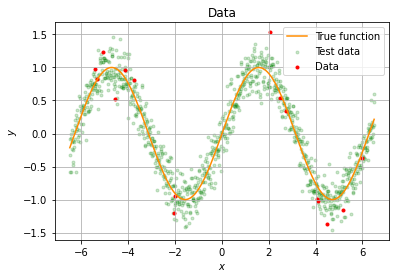

In [3]:
sigma = noise  = .2
num = train_size = 16
test_size = 1000
true_size = 1000

data_file = "02_small_and_shallow_networks.npz"
try:
    def unpack(x, y, x_test, y_test, x_true, y_true):
        return x, y, x_test, y_test, x_true, y_true
    x, y, x_test, y_test, x_true, y_true = unpack(**np.load(data_file))
    print("load data")
except Exception as e:
    print("create data")
    print(e)
    x, y, x_test, y_test, x_true, y_true = get_toy_data_3(sigma, train_size, test_size, true_size,use_hole=1)
    np.savez(data_file, x=x,y=y,x_test=x_test, y_test=y_test, x_true=x_true ,y_true=y_true)
y=np.reshape(y,[-1])
y_test=np.reshape(y_test,[-1])

plt.figure()
plt.scatter(x_test,y_test, marker='.', color='g',label=r"Test data",alpha=0.2)
plt.scatter(x,y, marker='.', color='r',label=r"Data")
plt.plot(x_true,y_true,color="darkorange",label=r"True function")
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Data');

## Common hyperparameter

In [4]:
# Number of epochs
epochs=20000

# Number of hidden units for the single hidden layer
num_hidden_units=3

# Number of samples psi to approximate the expected value
num_samples_per_epoch=100

# Range for the PPD
num_xx=3000
xx = np.linspace(-11, 11, num_xx).reshape(-1, 1)

# Number of predictions for the PPD
num_predictions=100

# Learning rate and clip norm
lr=0.03
#cn=2

# Train parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Prior
prior_params = {
    'prior_mu': 0., 
    'prior_sigma': 1.
}

prior_dist=tfd.Normal(loc=0.,scale=1.)

## Common functions

In [5]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

## Ground truth
*Note: MCMC code is only constructed for a single hidden layer network.*


In [6]:
use_mcmc=True

In [7]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [8]:
if use_mcmc:
  stan_code = """
functions {
	matrix selfmade_relu(matrix z, int a_rows, int a_columns){
	  matrix[a_rows, a_columns] a;
	  for (i in 1:a_rows){
			for (j in 1:a_columns){
				if(z[i,j]>0){
					a[i,j]=z[i,j];
				}
				else{
					a[i,j]=0;
				}
			}
	  }
	  return a;
	}

	vector calculate_mu(matrix X, matrix bias_first_m, matrix[] bias_middle_m,real bias_output, matrix w_first, matrix[] w_middle, vector w_output,int num_layers) {
		int N = rows(X);
		int num_nodes = rows(w_first);
		matrix[N, num_nodes] layer_values[num_layers - 1];
		vector[N] mu;

		layer_values[1] = selfmade_relu(bias_first_m + X * w_first',N,num_nodes); 
		for(i in 2:(num_layers - 1)) 
		  layer_values[i] = selfmade_relu(bias_middle_m[i - 1] + layer_values[i - 1] * w_middle[i - 1]',N,num_nodes);
		mu = bias_output + layer_values[num_layers - 1] * w_output;

		return mu;
	}
}
data {
  int<lower=0> N;
  int<lower=0> d;
  int<lower=0> num_nodes;
  int<lower=1> num_middle_layers;
  matrix[N,d] X;
  real y[N];
  int<lower=0> Nt;
  matrix[Nt,d] Xt;
  real<lower=0> sigma;					// Konstantes sigma
}
transformed data {
  int num_layers;
  num_layers = num_middle_layers + 1;
}
parameters {
  vector[num_nodes] bias_first;
  vector[num_nodes] bias_middle[num_middle_layers];
  real bias_output;
  matrix[num_nodes, d] w_first;
  matrix[num_nodes, num_nodes] w_middle[num_middle_layers];
  vector[num_nodes] w_output;
// hyperparameters
  real<lower=0> bias_first_h;
  vector<lower=0>[num_middle_layers] bias_middle_h; 
  real<lower=0> w_first_h;
  vector<lower=0>[num_middle_layers] w_middle_h;
  real<lower=0> w_output_h;
} 
transformed parameters {
  matrix[N, num_nodes] bias_first_m = rep_matrix(bias_first', N);
  matrix[N, num_nodes] bias_middle_m[num_layers - 2];

  for (i in 1:(num_layers - 2))
    bias_middle_m[i] = rep_matrix(bias_middle[i]', N);
}
model{
  vector[N] mu;
  mu = calculate_mu(X, bias_first_m, bias_middle_m, bias_output,
    w_first, w_middle, w_output, num_layers);
  y ~ normal(mu,sigma);
  
  //priors
  bias_first_h ~ normal(0, 1);
  bias_first ~ normal(0, bias_first_h);
  for (i in 1:num_middle_layers) {
    bias_middle_h[i] ~ normal(0, 1);
    bias_middle[i] ~ normal(0, bias_middle_h[i]);
  }
  bias_output ~ normal(0, 1);

  w_first_h ~ normal(0, 1);
  to_vector(w_first) ~ normal(0, w_first_h);
  for (i in 1:num_middle_layers) {
    w_middle_h[i] ~ normal(0, 1);
    to_vector(w_middle[i]) ~ normal(0, w_middle_h[i]);
  }
  w_output_h ~ normal(0, 1);
  w_output ~ normal(0, w_output_h);
}
generated quantities{
  vector[Nt] predictions;
  {
    matrix[Nt, num_nodes] bias_first_mg = rep_matrix(bias_first', Nt);
    matrix[Nt, num_nodes] bias_middle_mg[num_layers - 2];
    vector[Nt] mu;

    for (i in 1:(num_layers - 2))
      bias_middle_mg[i] = rep_matrix(bias_middle[i]', Nt);
    mu = calculate_mu(Xt, bias_first_mg, bias_middle_mg, bias_output,
      w_first, w_middle, w_output, num_layers);
    for(i in 1:Nt) 
      predictions[i] = normal_rng(mu[i],sigma); 
  }
}
  """
  model_mcmc=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_87d7678c696b5aba92d3d6f5188f2f04 NOW.


In [9]:
if use_mcmc:
    my_dat = {'N': num,
            'd': 1,
            'num_nodes': num_hidden_units,
            'num_middle_layers':1,
            'X': x,
            'y': y,
            'sigma': sigma,
            'Nt': num_xx,
            'Xt': xx,
            'y': y}

    fit_mcmc=model_mcmc.sampling(data=my_dat,iter=4000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
if use_mcmc:    
    samples_predictions=fit_mcmc.extract()['predictions']; 
    print(samples_predictions.shape)
    samples_predictions_mean=np.mean(samples_predictions,axis=0)
    samples_predictions_2p5=np.quantile(samples_predictions,0.025,axis=0)
    samples_predictions_97p5=np.quantile(samples_predictions,0.975,axis=0)
    samples_predictions_50p0=np.quantile(samples_predictions,0.5,axis=0)

(8000, 3000)


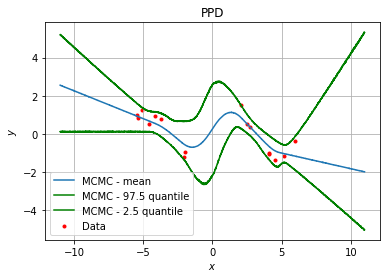

In [11]:
if use_mcmc:
    plt.plot(xx,samples_predictions_mean,label="MCMC - mean")
    plt.plot(xx,samples_predictions_97p5,color='g',label="MCMC - 97.5 quantile")
    #plt.plot(xx,samples_predictions_50p0,color='g',label="mcmc_50p0_quantile")
    plt.plot(xx,samples_predictions_2p5,color='g',label="MCMC - 2.5 quantile")
    plt.scatter(x,y, marker='.', color='r', label="Data")
    plt.legend()
    plt.grid()
    plt.ylabel(r"$y$")
    plt.xlabel(r"$x$")
    plt.title(r'PPD');

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


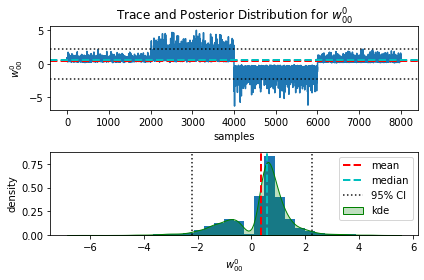

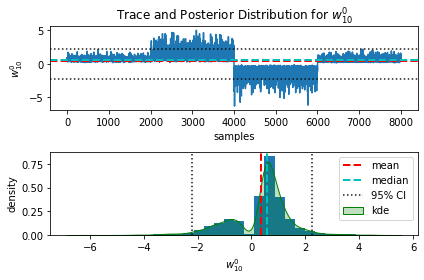

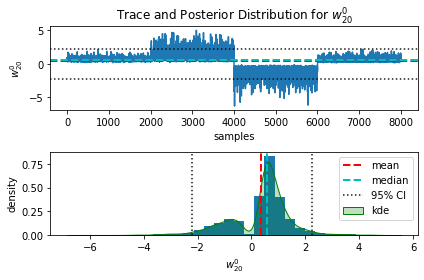

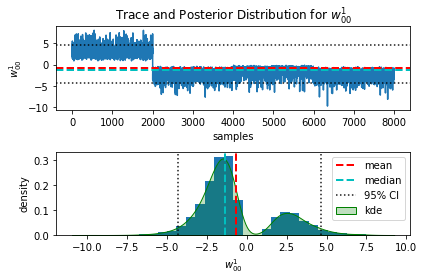

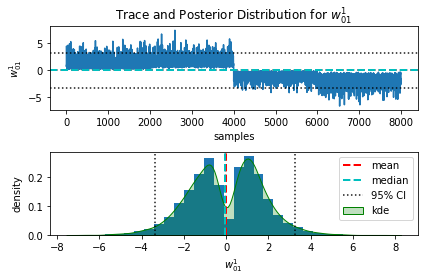

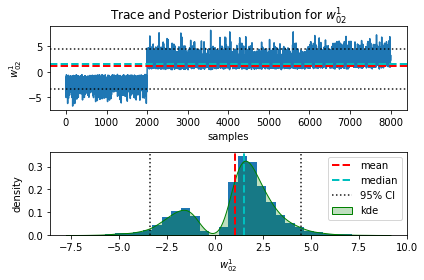

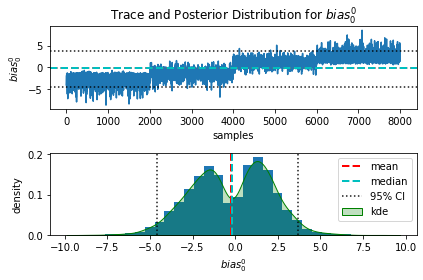

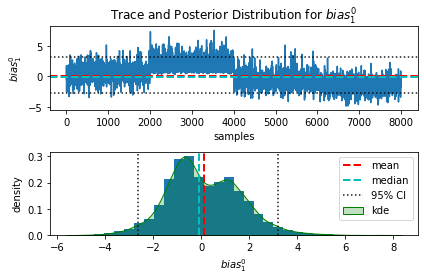

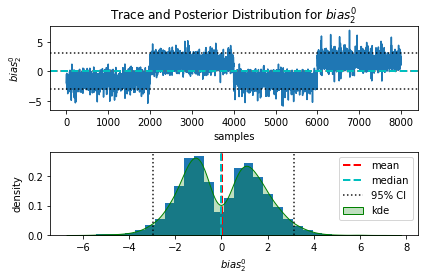

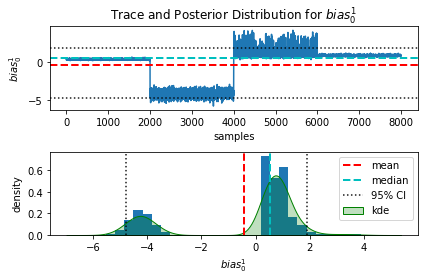

In [12]:
if use_mcmc:
    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_first'][:,0,0],r"$w^{0}_{"+str(i)+r"0}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_output'][:,i],r"$w^{1}_{0"+str(i)+r"}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['bias_first'][:,i],r"$bias^{0}_{"+str(i)+r"}$")

    plt.figure()
    plot_trace(fit_mcmc.extract()['bias_output'],r"$bias^{1}_{0}$")

## VIGAUSS

MFVI with a Gaussian as variational distribution

In [13]:
x_in = Input(shape=(1,),name="VIGAUSS_il")
x_arch = DenseVIGAUSS(units=num_hidden_units, activation='relu', kl_weight=kl_weight, name="VIGAUSS_hl_1", **prior_params )(x_in)
x_arch = DenseVIGAUSS(units=1, kl_weight=kl_weight, name="VIGAUSS_ol", **prior_params)(x_arch)

model_VIGAUSS = Model(x_in, x_arch,name="model_VIGAUSS")

In [14]:
print(model_VIGAUSS.summary())

Model: "model_VIGAUSS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIGAUSS_il (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
VIGAUSS_hl_1 (DenseVIGAUSS)  (None, 3)                 12        
_________________________________________________________________
VIGAUSS_ol (DenseVIGAUSS)    (None, 1)                 8         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood])
model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
callbacks_VIGAUSS = [
    #callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
]

# Fit the model to the data
hist=model_VIGAUSS.fit(x, y, callbacks=callbacks_VIGAUSS, batch_size=batch_size, epochs=epochs, verbose=0);

## VIMLTS

MFVI with a flexible variational distribution

### functions

In [17]:
def get_lambdas_for_w(layer_weights, from_neuron_layer_bevore, to_neuron):
    """
        Gets the variational parameter for a specific weight
    """  
    try:
        num_param=14
        lambdas=[]
        
        for j in range(int(num_param)):
            lambdas.append(layer_weights[j][from_neuron_layer_bevore][to_neuron])
        return lambdas
    except:
        print("Constellation not existing")


def get_lambdas_for_bias(layer_weights, neuron):
    """
        Gets the variational parameter for a specific bias
    """  
    try:
        num_param=14
        lambdas=[]
 
        for j in range(num_param,num_param*2):
            lambdas.append(layer_weights[j][neuron])
        return lambdas
    except:
        print("Constellation not existing")

@tf.function
def neg_log_likelihood_s(y_obs, y_pred, sigma=noise):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    # dist = tfp.distributions.Normal(loc=y_pred, scale=scale)
    dist = tfd.Normal(loc=y_pred, scale=sigma)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

In [36]:
M=10
theta_start = -5
theta_stop = 5
vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)],
                             bias_init_alpha_w = initializers.Constant(1.),
                             bias_init_beta_w = initializers.Constant(0.),
                             bias_init_alpha_z = initializers.Constant(1.),
                             bias_init_beta_z = initializers.Constant(0.),
                             bias_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])

In [37]:
x_in = Input(shape=(1,), name="VIMLTS_il")
x_arch = VimltsLinear(units=num_hidden_units,
                      activation=tf.keras.activations.relu,
                      num_samples=num_samples_per_epoch,
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x_in)
x_arch = VimltsLinear(units=1,
                      activation=tf.keras.activations.relu,
                      num_samples=num_samples_per_epoch,
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x_arch)

model_VIMLTS = Model(x_in, x_arch, name="model_VIMLTS")
model_VIMLTS.summary()

Model: "model_VIMLTS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIMLTS_il (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_2 (VimltsLinea (1000, None, 3)           90        
_________________________________________________________________
vimlts_linear_3 (VimltsLinea (1000, None, 1)           60        
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


Plot an initialization of the variational distribution

In [38]:
#model_VIMLTS.compile(loss=neg_log_likelihood_s, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood_s])
model_VIMLTS.compile(loss=neg_log_likelihood_s, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood_s])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
# Number of checkpoints, to save the variational distribution during the training
checkpoints=50

subepochs=int(epochs/checkpoints)
hist_weights=[]

class callback_save_weights(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # true
        if(epoch%subepochs==0):
            print("checkpoint:\t",int(epoch/subepochs),"\tloss:\t",logs["loss"])
            layer_weights=[]
            for layer in range(np.shape(self.model.layers)[0]):
                layer_weights.append(self.model.layers[layer].get_weights()[:])

            hist_weights.append(layer_weights)


callbacks_VIMLTS = [
        callback_save_weights()
]

# Fit the model to the data
hist_VIMLTS=model_VIMLTS.fit(x, y, callbacks=callbacks_VIMLTS, batch_size=batch_size, epochs=epochs, verbose=0)

checkpoint:	 0 	loss:	 160462.21875
checkpoint:	 1 	loss:	 220.64923095703125
checkpoint:	 2 	loss:	 226.39959716796875
checkpoint:	 3 	loss:	 216.09519958496094
checkpoint:	 4 	loss:	 217.6365203857422
checkpoint:	 5 	loss:	 212.3304443359375
checkpoint:	 6 	loss:	 213.0678253173828
checkpoint:	 7 	loss:	 211.2162628173828
checkpoint:	 8 	loss:	 208.90208435058594
checkpoint:	 9 	loss:	 211.794189453125
checkpoint:	 10 	loss:	 208.7447509765625
checkpoint:	 11 	loss:	 206.6650848388672
checkpoint:	 12 	loss:	 207.3331298828125
checkpoint:	 13 	loss:	 203.775146484375
checkpoint:	 14 	loss:	 205.7615966796875
checkpoint:	 15 	loss:	 203.74667358398438
checkpoint:	 16 	loss:	 201.61355590820312
checkpoint:	 17 	loss:	 200.2571563720703
checkpoint:	 18 	loss:	 199.9611053466797
checkpoint:	 19 	loss:	 200.44618225097656
checkpoint:	 20 	loss:	 198.4493408203125
checkpoint:	 21 	loss:	 199.15541076660156
checkpoint:	 22 	loss:	 197.251708984375
checkpoint:	 23 	loss:	 197.04600524902344
c

## Analyse the run

### Analyse the loss

Minimum Loss VIMLTS:		 187.57269287109375
Minimum Loss VIMLTS an Epoche:	 3980
Loss nach Training VIMLTS:	 187.98529052734375
Loss nach Training VIGAUSS:	 105.58601379394531


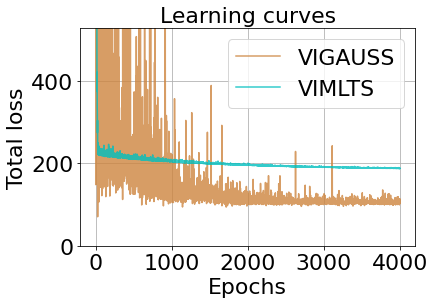

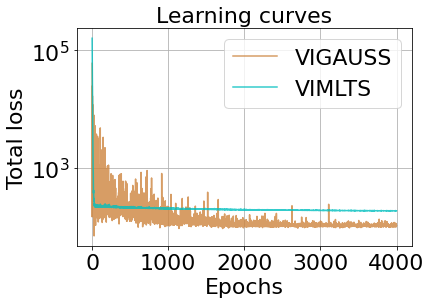

In [40]:
loss_model_VIGAUSS=hist.history['loss'][np.shape(hist.history['loss'])[0]-1]
loss_model_VIMLTS=hist_VIMLTS.history['loss'][np.shape(hist_VIMLTS.history['loss'])[0]-1]
loss_min_VIMLTS=np.min(hist_VIMLTS.history['loss'])
loss_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['loss'])

print("Minimum Loss VIMLTS:\t\t",loss_min_VIMLTS)
print("Minimum Loss VIMLTS an Epoche:\t",loss_min_epoche_VIMLTS)
print("Loss nach Training VIMLTS:\t",loss_model_VIMLTS)
print("Loss nach Training VIGAUSS:\t",loss_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.ylim([0, loss_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.yscale('log')


Show a noise reduced curve

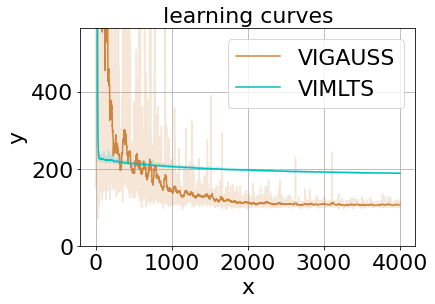

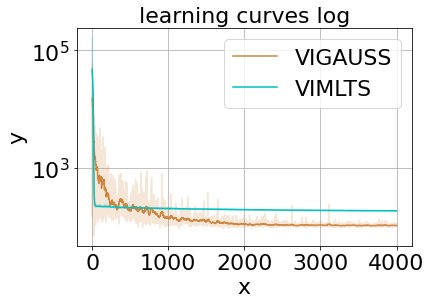

In [41]:
loss_VIGAUSS_hat = scipy.signal.savgol_filter(hist.history['loss'], 31, 1) # window size 31, polynomial order 1
loss_VIMLTS_hat = scipy.signal.savgol_filter(hist_VIMLTS.history['loss'], 31, 1) # window size 31, polynomial order 1

title=r"learning curves"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.ylim([0, loss_model_VIMLTS*3])
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title(title)
plt.show()

title=r"learning curves log"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.yscale('log')
plt.title(title)
plt.show()

### Analyse the NLL

Minimum NLL VIMLTS:		 182.31576538085938
Minimum NLL VIMLTS an Epoche:	 3334
NLL nach Training VIMLTS:	 182.69821166992188
NLL nach Training VIGAUSS:	 84.02558898925781


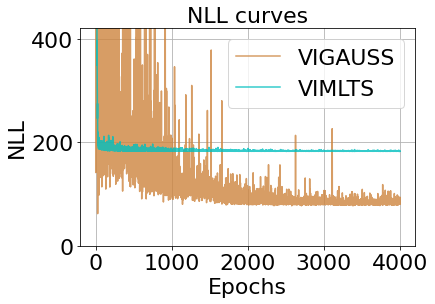

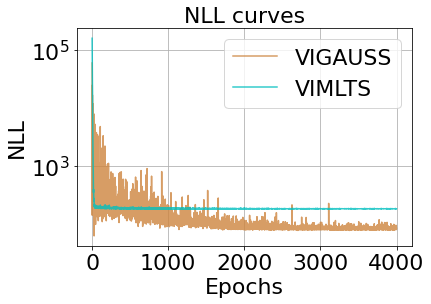

In [42]:
NLL_model_VIGAUSS=hist.history['neg_log_likelihood'][np.shape(hist.history['neg_log_likelihood'])[0]-1]
NLL_model_VIMLTS=hist_VIMLTS.history['neg_log_likelihood_s'][np.shape(hist_VIMLTS.history['neg_log_likelihood_s'])[0]-1]
NLL_min_VIMLTS=np.min(hist_VIMLTS.history['neg_log_likelihood_s'])
NLL_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['neg_log_likelihood_s'])

print("Minimum NLL VIMLTS:\t\t",NLL_min_VIMLTS)
print("Minimum NLL VIMLTS an Epoche:\t",NLL_min_epoche_VIMLTS)
print("NLL nach Training VIMLTS:\t",NLL_model_VIMLTS)
print("NLL nach Training VIGAUSS:\t",NLL_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood_s'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'NLL curves');
plt.grid()
plt.legend()
plt.ylim([0, NLL_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood_s'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'NLL curves');
plt.grid()
plt.legend()
plt.yscale('log')


## Predictive

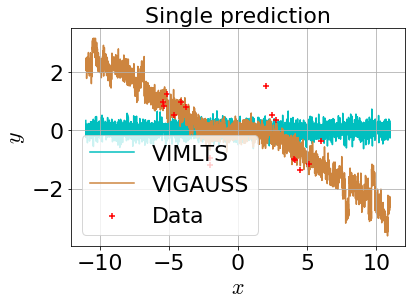

In [43]:
mu_VIGAUSS = model_VIGAUSS.predict(xx)
y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()

mu_VIMLTS = tf.reduce_mean(model_VIMLTS(xx),axis=0)
y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()


plt.plot(xx,y_pred_VIMLTS,zorder=0, label=r'VIMLTS',color='c')
plt.plot(xx,y_pred_VIGAUSS,zorder=0,label=r'VIGAUSS',color='peru')
plt.scatter(x, y, marker='+',c='r',zorder=1, label=r'Data')
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Single prediction');

In [44]:
# VIMLTS
y_pred_list = []

# VIGAUSS
y_pred_list_VIGAUSS = []

# Iterate over number of predictions
for i in tqdm.tqdm(range(num_predictions)):
    # VIMLTS
    mu_VIMLTS = tf.reduce_mean(model_VIMLTS(xx),axis=0)
    y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()
    y_pred_list.append(y_pred_VIMLTS)

    # VIGAUSS
    mu_VIGAUSS = model_VIGAUSS.predict(xx)
    y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()
    y_pred_list_VIGAUSS.append(y_pred_VIGAUSS)

# VIMLTS
y_preds = np.concatenate(y_pred_list, axis=1)
y_predictions_mean=np.mean(y_preds,axis=1)
y_predictions_2p5=np.quantile(y_preds,0.025,axis=1)
y_predictions_97p5=np.quantile(y_preds,0.975,axis=1)
y_predictions_50p0=np.quantile(y_preds,0.5,axis=1)

# VIGAUSS
y_preds_VIGAUSS = np.concatenate(y_pred_list_VIGAUSS, axis=1)
y_predictions_mean_VIGAUSS=np.mean(y_preds_VIGAUSS,axis=1)
y_predictions_2p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.025,axis=1)
y_predictions_97p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.975,axis=1)
y_predictions_50p0_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.5,axis=1)


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


FileNotFoundError: ignored

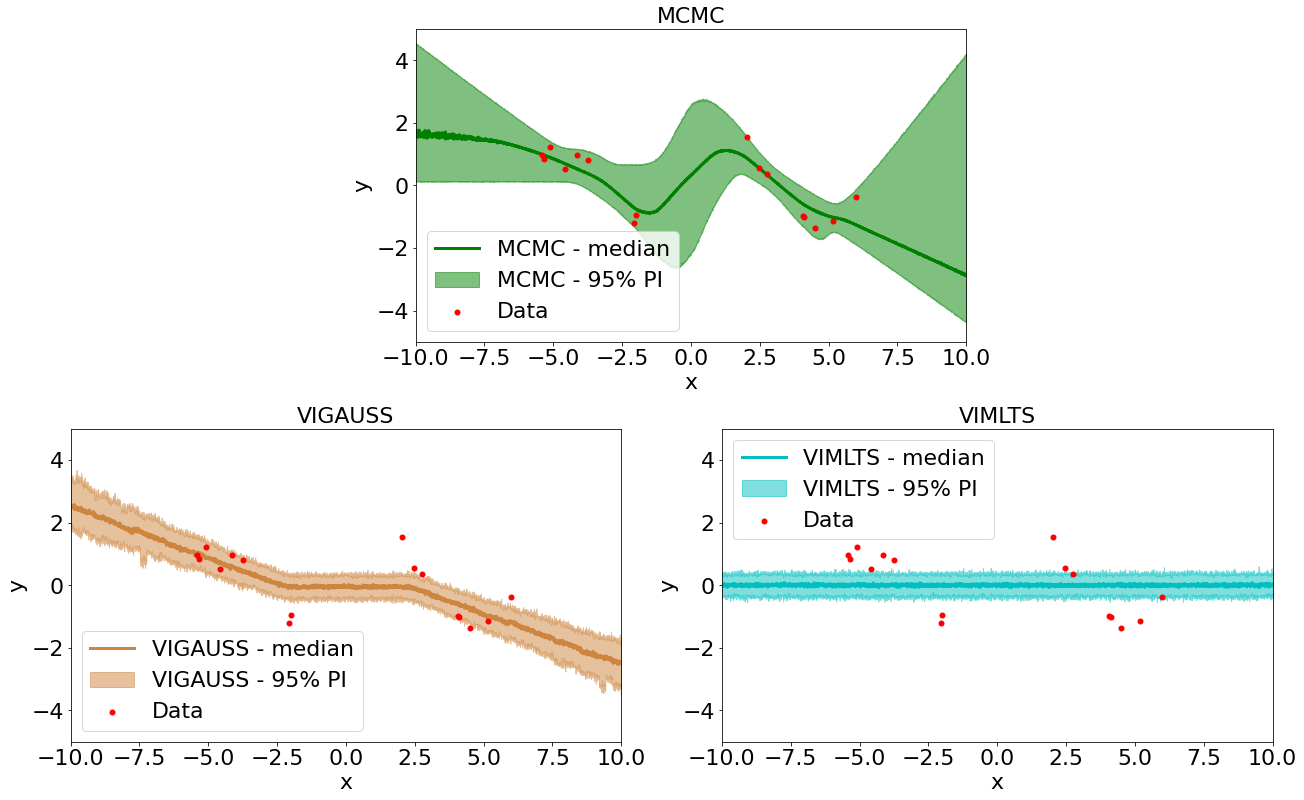

In [45]:
fig = plt.figure(constrained_layout=True, figsize=(18,11))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 1:3])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[1, 2:4])

#fig.tight_layout(pad=0.0)

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22)

plt.rcParams['mathtext.fontset'] = 'cm'

linewidth=3

ax1.fill_between(xx.reshape(-1),samples_predictions_97p5,samples_predictions_2p5, color='g', alpha=0.5, label=(r"MCMC - 95% PI"))
ax1.plot(xx,samples_predictions_50p0, color='g' ,label=(r"MCMC - median"), linewidth=linewidth)
ax1.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth,  zorder=10)
ax1.set_xlim([-10,10])
ax1.set_ylim([-5,5])
ax1.set_xlabel(r'x')
ax1.set_ylabel(r'y')
ax1.set_title(r'MCMC')

ax1.legend()

ax2.fill_between(xx.reshape(-1),y_predictions_97p5_VIGAUSS,y_predictions_2p5_VIGAUSS, color='peru', alpha=0.5, label=(r"VIGAUSS - 95% PI"))
#ax2.plot(x_test_hello_world,vimlt_predictions_mean_hello_world, color='peru' ,label=(r"VIMLT - mean"))
ax2.plot(xx,y_predictions_50p0_VIGAUSS, color='peru' ,label=(r"VIGAUSS - median"), linewidth=linewidth)
ax2.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax2.set_xlim([-10,10])
ax2.set_ylim([-5,5])
ax2.set_xlabel(r'x')
ax2.set_ylabel(r'y')
ax2.set_title(r'VIGAUSS')
ax2.legend()


ax3.fill_between(xx.reshape(-1),y_predictions_97p5,y_predictions_2p5, color='c', alpha=0.5, label=(r"VIMLTS - 95% PI"))
#ax3.plot(x_test_hello_world,vimlts_predictions_mean_hello_world, color='c' ,label=(r"VIMLTS - mean"))
ax3.plot(xx,y_predictions_50p0, color='c' ,label=(r"VIMLTS - median"), linewidth=linewidth)
ax3.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax3.set_xlim([-10,10])
ax3.set_ylim([-5,5])
ax3.set_xlabel(r'x')
ax3.set_ylabel(r'y')
ax3.set_title(r'VIMLTS')
ax3.legend()

plt.savefig('output/bnn_ms_ppd.svg', format='svg')
plt.savefig('output/bnn_ms_ppd.pdf', format='pdf')

Evaluate the model with the NLL

In [ ]:
VIGAUSS_NLL_test_list = []
VIMLTS_NLL_test_list = []
num_evaluations=20

for i in range(num_evaluations):
    clear_output()
    print("round:\t",i,"/",num_evaluations)
    VIGAUSS_NLL_test_list.append(model_VIGAUSS.evaluate(x_test, y_test, batch_size=batch_size)[1])
    VIMLTS_NLL_test_list.append(model_VIMLTS.evaluate(x_test, y_test, batch_size=batch_size)[1])

VIGAUSS_NLL_test_mean=np.mean(VIGAUSS_NLL_test_list)
VIGAUSS_NLL_test_median=np.median(VIGAUSS_NLL_test_list)
VIMLTS_NLL_test_mean=np.mean(VIMLTS_NLL_test_list)
VIMLTS_NLL_test_median=np.median(VIMLTS_NLL_test_list)
print()
print()
print("VIGAUSS NLL test mean:\t\t",VIGAUSS_NLL_test_mean)
print("VIMLTS NLL test mean:\t\t",VIMLTS_NLL_test_mean)


print("VIGAUSS NLL test median:\t",VIGAUSS_NLL_test_median)
print("VIMLTS NLL test median:\t\t",VIMLTS_NLL_test_median)


# Save the variables

In [ ]:
import pandas as pd
import pickle

In [ ]:
lambdas_VIMLTS_03_shallow_layer_1=model_VIMLTS.layers[1].get_weights()[:]
lambdas_VIMLTS_03_shallow_layer_2=model_VIMLTS.layers[2].get_weights()[:]

In [ ]:
df_03_lambdas=pd.DataFrame()
df_03_lambdas['lambdas_VIMLTS_03_shallow_layer_1']=lambdas_VIMLTS_03_shallow_layer_1
df_03_lambdas['lambdas_VIMLTS_03_shallow_layer_2']=lambdas_VIMLTS_03_shallow_layer_2

In [ ]:
if use_mcmc:
    df_03_mcmc_weights=pd.DataFrame()
    for i in range(num_hidden_units):
        df_03_mcmc_weights["w_0_"+str(i)+"0"]=fit_mcmc.extract()['w_first'][:,0,0]

    for i in range(num_hidden_units):
        df_03_mcmc_weights["w_1_0"+str(i)]=fit_mcmc.extract()['w_output'][:,i]

    for i in range(num_hidden_units):
        df_03_mcmc_weights["b_0_"+str(i)]=fit_mcmc.extract()['bias_first'][:,i]

    df_03_mcmc_weights["b_1_0"]=fit_mcmc.extract()['bias_output']

In [ ]:
pickle.dump( df_03_lambdas, open( "df_03_lambdas.p", "wb" ) )
pickle.dump( df_03_mcmc_weights, open( "df_03_mcmc_weights.p", "wb" ) )